In [7]:
!pip install einops


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


# Imports

In [ ]:
import numpy as np
import pandas as pd
import transformers
import tensorflow as tf
import tqdm.notebook as tqdm
import sklearn.model_selection
import matplotlib.pyplot as plt

In [1]:
import os
import math
import numpy as np
import pandas as pd
import transformers
from datasets import load_dataset
#import tensorflow as tf
import tqdm.notebook as tqdm
import sklearn.model_selection
import matplotlib.pyplot as plt

import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.decomposition import PCA

import torch
import torchvision
from torchinfo import summary

/home/bob1ch/Рабочий стол/NN-NLP/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device='cuda'

# Data

Load and prepare your dataset. Dataset should have at least 10k samples in it. Each dataset cannot be used by more than two students.

In [3]:
dataset = load_dataset('dair-ai/emotion')

In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [780]:
dataset['train']['text'][3]

'i am ever feeling nostalgic about the fireplace i will know that it is still on the property'

In [764]:
class2idx = {'sadness': 0, 'joy': 1, 'love': 2, 'anger': 3, 'fear': 4, 'surprise': 5}
idx2class = {v:k for k,v in class2idx.items()}

# Backbone

Load pretrained model from Hugging Face (or some other model repository if it's more convenient). Model should be trained on Feature Extraction task.

In [5]:
#'michellejieli/emotion_text_classifier'

In [29]:
backbone = transformers.AutoModel.from_pretrained('jinaai/jina-embeddings-v3').to(device)

The repository for jinaai/jina-embeddings-v3 contains custom code which must be executed to correctly load the model. You can inspect the repository content at https://hf.co/jinaai/jina-embeddings-v3.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N]  y


flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn i

Load tokenizer to be used with the model

In [33]:
tokenizer = transformers.AutoTokenizer.from_pretrained('jinaai/jina-embeddings-v3')

# Feature extraction

Since we will not be training the backbone, extract features from your dataset.

Tokenize all your sequences. Truncate/pad the squences for convenience. If the sequences are too large to be stored in memory, lazily save them on disk.

In [34]:
np.median(list(map(len, tokenizer(dataset['train']['text'])['input_ids'])))

np.float64(22.0)

In [35]:
tokenized_train = (tokenizer(dataset['train']['text'], return_tensors='pt', truncation=True, padding='max_length', max_length=22), dataset['train']['label'])
tokenized_val = (tokenizer(dataset['validation']['text'], return_tensors='pt', truncation=True, padding='max_length', max_length=22), dataset['validation']['label'])
tokenized_test = (tokenizer(dataset['test']['text'], return_tensors='pt', truncation=True, padding='max_length', max_length=22), dataset['test']['label'])

In [36]:
backbone(tokenized_train[0]['input_ids'][0:1]).pooler_output.shape

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument index in method wrapper_CUDA__index_select)

In [37]:
class Tokenized_dataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        super().__init__()
        self.X1 = torch.Tensor(X['input_ids']).to(device)
        self.y = torch.Tensor(y).to(device, dtype=torch.int32)
        
    def __getitem__(self, i):
        return self.X1[i], self.y[i]

    def __len__(self):
        return len(self.X1)

In [38]:
tokenizer_data = Tokenized_dataset(*tokenized_train)
tokenizer_data_loader = torch.utils.data.DataLoader(tokenizer_data, batch_size=256, shuffle=False)

vectorized_train = []
train_y = []

for i, batch in enumerate(tokenizer_data_loader):
    inp, y = batch
    vectorized_train.extend(backbone(inp).pooler_output.tolist())
    train_y.extend(y.tolist())
    print(f'{(i+1) / len(tokenizer_data_loader) * 100} %')

1.5873015873015872 %
3.1746031746031744 %
4.761904761904762 %
6.349206349206349 %
7.936507936507936 %
9.523809523809524 %
11.11111111111111 %
12.698412698412698 %
14.285714285714285 %
15.873015873015872 %
17.46031746031746 %
19.047619047619047 %
20.634920634920633 %
22.22222222222222 %
23.809523809523807 %
25.396825396825395 %
26.984126984126984 %
28.57142857142857 %
30.158730158730158 %
31.746031746031743 %
33.33333333333333 %
34.92063492063492 %
36.507936507936506 %
38.095238095238095 %
39.682539682539684 %
41.269841269841265 %
42.857142857142854 %
44.44444444444444 %
46.03174603174603 %
47.61904761904761 %
49.2063492063492 %
50.79365079365079 %
52.38095238095239 %
53.96825396825397 %
55.55555555555556 %
57.14285714285714 %
58.730158730158735 %
60.317460317460316 %
61.904761904761905 %
63.49206349206349 %
65.07936507936508 %
66.66666666666666 %
68.25396825396825 %
69.84126984126983 %
71.42857142857143 %
73.01587301587301 %
74.60317460317461 %
76.19047619047619 %
77.77777777777779 %
7

In [39]:
tokenizer_data = Tokenized_dataset(*tokenized_val)
tokenizer_data_loader = torch.utils.data.DataLoader(tokenizer_data, batch_size=256, shuffle=False)

vectorized_val = []
val_y = []

for i, batch in enumerate(tokenizer_data_loader):
    inp, y = batch
    vectorized_val.extend(backbone(inp).pooler_output.tolist())
    val_y.extend(y.tolist())
    print(f'{(i+1) / len(tokenizer_data_loader) * 100} %')

12.5 %
25.0 %
37.5 %
50.0 %
62.5 %
75.0 %
87.5 %
100.0 %


In [40]:
tokenizer_data = Tokenized_dataset(*tokenized_test)
tokenizer_data_loader = torch.utils.data.DataLoader(tokenizer_data, batch_size=256, shuffle=False)

vectorized_test = []
test_y = []

for i, batch in enumerate(tokenizer_data_loader):
    inp, y = batch
    vectorized_test.extend(backbone(inp).pooler_output.tolist())
    test_y.extend(y.tolist())
    print(f'{(i+1) / len(tokenizer_data_loader) * 100} %')

12.5 %
25.0 %
37.5 %
50.0 %
62.5 %
75.0 %
87.5 %
100.0 %


In [41]:
with open('train_vect.pkl', 'wb') as f:
    pickle.dump(vectorized_train, f)
with open('train_y.pkl', 'wb') as f:
    pickle.dump(train_y, f)

with open('val_vect.pkl', 'wb') as f:
    pickle.dump(vectorized_val, f)
with open('val_y.pkl', 'wb') as f:
    pickle.dump(val_y, f)

with open('test_vect.pkl', 'wb') as f:
    pickle.dump(vectorized_test, f)
with open('test_y.pkl', 'wb') as f:
    pickle.dump(test_y, f)

Run the backbone on the sequences and save the extracted features. The extracted features should be a vector containing information about the whole text. If the features are too large to be stored in memory, lazily save them on disk.

# Prepare train/test data

Split your data (extracted features and labels) into train and test subsets.

In [28]:
X_train, X_test, y_train, y_test = train_test_split(vectorized_train, train_y, shuffle=True, train_size=0.7)

Prepare `tf.data.Dataset` or some other way for the data to be used during training.

In [42]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        super().__init__()
        self.X = torch.Tensor(X).to(device, dtype=torch.float32)
        self.y = torch.LongTensor(y).to(device)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

    def __len__(self):
        return len(self.X)

In [31]:
train_data = Dataset(X_train, y_train)
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=512, shuffle=True)

val_data = Dataset(X_test, y_test)
val_data_loader = torch.utils.data.DataLoader(val_data, batch_size=512, shuffle=True)

# test_data = Dataset(vectorized_test, test_y)
# test_data_loader = torch.utils.data.DataLoader(test_data, batch_size=128, shuffle=True)

In [43]:
train_data = Dataset(vectorized_train, train_y)
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)

val_data = Dataset(vectorized_val, val_y)
val_data_loader = torch.utils.data.DataLoader(val_data, batch_size=128, shuffle=True)

test_data = Dataset(vectorized_test, test_y)
test_data_loader = torch.utils.data.DataLoader(test_data, batch_size=128, shuffle=True)

# Build the model

Build a simple model. The model should accept an extracted feature vector and return a vector of class logits (or probabilities). Model should only have a couple (or even 1) layer with weights.

In [800]:
class Model(torch.nn.Module):
    def __init__(self, n_classes, backbone):
        super(Model, self).__init__()
        self.backbone = backbone
        self.L1 = torch.nn.LazyLinear(512)
        self.dropout = torch.nn.Dropout(0.4)
        self.classifier = torch.nn.LazyLinear(n_classes)

    def forward(self, x, inp_text):
        if inp_text is not None:
            x = self.backbone(inp_text).pooler_output.to(dtype=torch.float)
        x = self.dropout(x)
        x = self.L1(x)
        x = torch.nn.functional.relu(x)
        #x = torch.flatten(x)
        #x = x.view(x.shape[0], -1)
        x = self.dropout(x)
        out = self.classifier(x)
        return out

In [801]:
model = Model(len(np.unique(train_y)), backbone).to(device)

In [802]:
summary(model)

Layer (type:depth-idx)                                                           Param #
Model                                                                            559,364,096
├─XLMRobertaLoRA: 1-1                                                            --
│    └─XLMRobertaModel: 2-1                                                      --
│    │    └─XLMRobertaEmbeddings: 3-1                                            261,044,092
│    │    └─Dropout: 3-2                                                         --
│    │    └─LayerNorm: 3-3                                                       (2,048)
│    │    └─XLMRobertaEncoder: 3-4                                               310,173,696
│    │    └─XLMRobertaPooler: 3-5                                                1,090,560
├─LazyLinear: 1-2                                                                --
├─Dropout: 1-3                                                                   --
├─LazyLinear: 1-4               

Compile the model. Choose loss and metrics.

<BarContainer object of 6 artists>

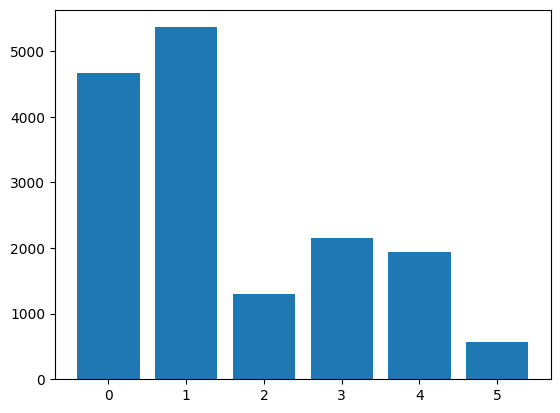

In [803]:
plt.bar(*np.unique(train_y, return_counts=True))

In [804]:
counts = torch.unique(torch.Tensor(train_y).to(device), return_counts=True)[-1] #торч требовал чтобы weights был torch.Tensor
weights = (1/counts) * (sum(counts) / len(counts))
weights

tensor([0.5715, 0.4973, 2.0450, 1.2351, 1.3767, 4.6620], device='cuda:0')

In [805]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#criterion = torch.nn.CrossEntropyLoss(weight=weights).to(device)
criterion = torch.nn.CrossEntropyLoss().to(device)

# Train the model

In [806]:
def metric(y, y_logits):
    return ((y == y_logits.argmax(dim=-1)).sum() / len(y)).tolist()

In [807]:
def train_epoch(model, optimizer, criterion, data):
    model.train()
    total_loss = 0
    total_metric = 0

    for x, y in data:
        optimizer.zero_grad()
        y_pred = model(x, None)
        loss = criterion(y_pred, y)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_metric += metric(y, y_pred)

    return total_loss / len(data), total_metric / len(data)

In [808]:
def evaluate(model, criterion, data):
    model.eval()
    total_loss = 0
    total_metric = 0
    with torch.no_grad():
        for x, y in data:
            y_pred = model(x, None)
            loss = criterion(y_pred, y)
            total_loss += loss.item()
            total_metric += metric(y, y_pred)

    return total_loss / len(data), total_metric / len(data)

In [809]:
def train(model, optimizer, criterion, train_data, test_data, epochs, print_every=1):
    train_plot = []
    eval_plot = []
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
    for epoch in range(epochs):
        train_loss, train_metric = train_epoch(model, optimizer, criterion, train_data)
        eval_loss, eval_metric = evaluate(model, criterion, test_data)
        #scheduler.step(eval_loss)
        train_plot.append(train_loss)
        eval_plot.append(eval_loss)
        if (epoch+1) % print_every == 0:
            print(f'EPOCH: {epoch+1}')
            print(f'TRAIN: {train_loss :.2f} loss | {train_metric * 100 :.2f}% metric')
            print(f'EVAL: {eval_loss :.2f} loss | {eval_metric * 100 :.2f}% metric')
            print(f'LR: {scheduler.get_last_lr()}')
            print('='*40)
            
    plt.plot(range(epochs), train_plot, label='train')
    plt.plot(range(epochs), eval_plot, label='val')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend()

EPOCH: 10
TRAIN: 1.02 loss | 58.80% metric
EVAL: 0.98 loss | 62.14% metric
LR: [0.001]
EPOCH: 20
TRAIN: 0.88 loss | 63.49% metric
EVAL: 0.98 loss | 64.68% metric
LR: [0.001]
EPOCH: 30
TRAIN: 0.77 loss | 67.17% metric
EVAL: 0.99 loss | 64.54% metric
LR: [0.001]
EPOCH: 40
TRAIN: 0.69 loss | 69.57% metric
EVAL: 1.01 loss | 64.40% metric
LR: [0.001]
EPOCH: 50
TRAIN: 0.63 loss | 71.51% metric
EVAL: 1.10 loss | 66.06% metric
LR: [0.001]


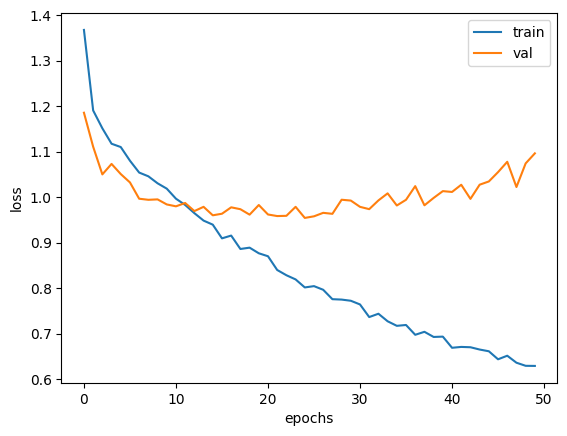

In [794]:
#здесь я применил веса и получилось хуже(
train(model, optimizer, criterion, train_data_loader, val_data_loader, 50, print_every=10)

EPOCH: 10
TRAIN: 0.92 loss | 65.76% metric
EVAL: 0.88 loss | 67.69% metric
LR: [0.001]
EPOCH: 20
TRAIN: 0.82 loss | 69.97% metric
EVAL: 0.86 loss | 68.70% metric
LR: [0.001]
EPOCH: 30
TRAIN: 0.73 loss | 72.63% metric
EVAL: 0.84 loss | 69.84% metric
LR: [0.001]
EPOCH: 40
TRAIN: 0.68 loss | 75.17% metric
EVAL: 0.85 loss | 68.54% metric
LR: [0.001]
EPOCH: 50
TRAIN: 0.63 loss | 76.60% metric
EVAL: 0.85 loss | 68.32% metric
LR: [0.001]


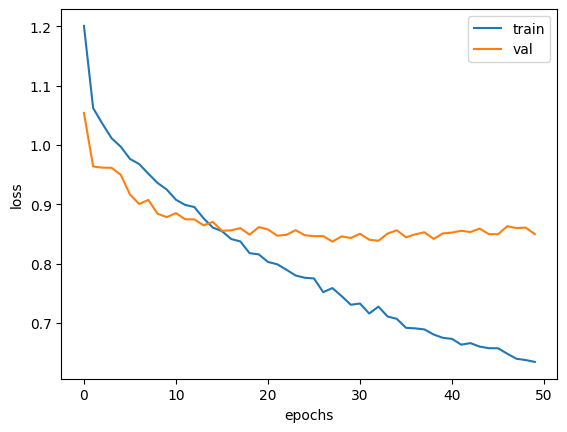

In [810]:
train(model, optimizer, criterion, train_data_loader, val_data_loader, 50, print_every=10)

# Evaluation

Evalute the model on test data.

In [811]:
print('TEST DATA: loss = {0:.2f}, metric = {1:.2f}%'.format(*evaluate(model, criterion, test_data_loader)))

TEST DATA: loss = 0.88, metric = 0.69%


Plot confusion matrix.

[Text(0, 0, 'sadness'),
 Text(0, 1, 'joy'),
 Text(0, 2, 'love'),
 Text(0, 3, 'anger'),
 Text(0, 4, 'fear'),
 Text(0, 5, 'surprise')]

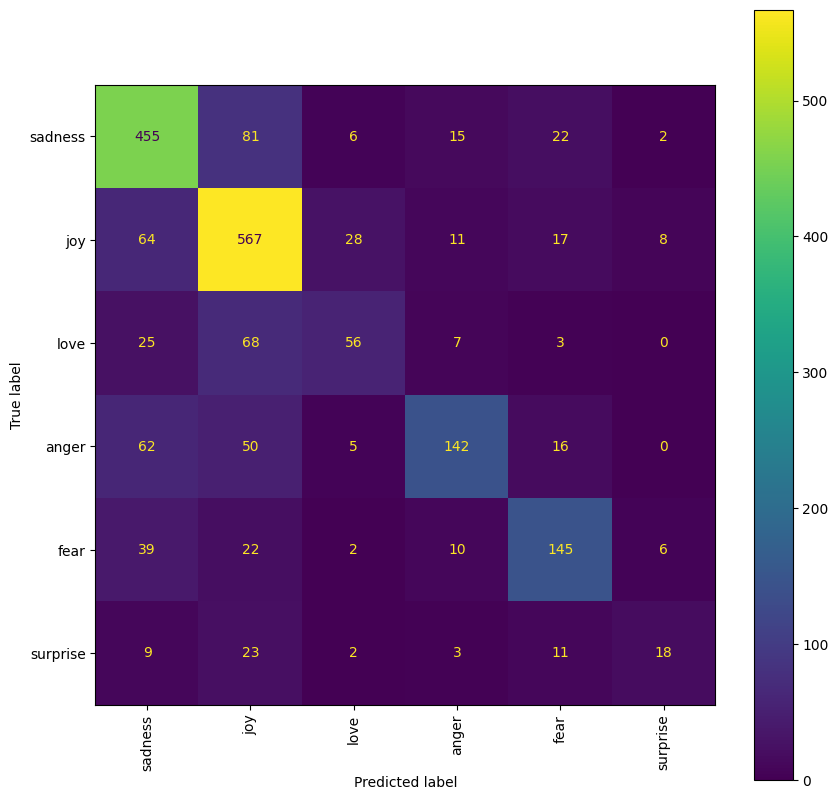

In [812]:
#vectorized_test, test_y
y_preds = model(torch.Tensor(vectorized_test).to(device), None).argmax(dim=-1)
fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(test_y, y_preds.cpu(), ax=ax)
ax.xaxis.set_ticklabels(class2idx.keys())
ax.tick_params(axis='x', labelrotation=90)
ax.yaxis.set_ticklabels(class2idx.keys())

Write a function to classify a piece of text.

In [813]:
def classify_text(text: str) -> tuple[int | str, np.ndarray]:
    '''Classifes the given `text` using the trained model.

    Arguments:
        text: text to be classified

    Return:
        The assigned label and probabilites of all labels'''
    model.eval()
    text = tokenizer(text, return_tensors='pt')['input_ids'].to(device)
    res = model(None, text)
    return res.argmax(dim=-1).item()

Evaluate the model on text not present in training and test data (come up with the text yourself). Try to get an input for each class.

In [817]:
idx2class.values()

dict_values(['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'])

In [952]:
corpus = ['Hello honey:)', 
          'Joker, are you mad?!', 
          'Happy birthday!', 
          'i miss my neighborhood',
          'Dad, check for monsters under the bed',
          'For the first time, this old fighter was surprised to feel tired',
          'It was a surprise!',
          'i love you',
          'i hate you',
          'i get good mark',]
for doc in corpus:
    print(f' "{doc}" are {idx2class[classify_text(doc)]} sentence')

 "Hello honey:)" are love sentence
 "Joker, are you mad?!" are anger sentence
 "Happy birthday!" are joy sentence
 "i miss my neighborhood" are sadness sentence
 "Dad, check for monsters under the bed" are fear sentence
 "For the first time, this old fighter was surprised to feel tired" are sadness sentence
 "It was a surprise!" are surprise sentence
 "i love you" are love sentence
 "i hate you" are anger sentence
 "i get good mark" are joy sentence


# Bonus

Write a function that computes word impact on text label. 

In [953]:
def get_words_impact(text: str) -> list[tuple[str, np.ndarray]]:
    '''Determines word impact on text label.

    Arguments:
        text: Sample text to be used for computation.

    Returns:
        A list of pairs: the word and vector of probability changes for each class'''
    model.eval()
    words = text.split()
    
    res = []
    for word in words:
        text_without_word  = text.split().copy()
        text_without_word.remove(word)
        text_without_word = ''.join(text_without_word)
        text_without_word = tokenizer(text_without_word, return_tensors='pt')['input_ids'].to(device)
        probs = model(None, text_without_word)
        res.append((word, torch.nn.functional.softmax(probs).tolist()[0]))
    return res

In [954]:
get_words_impact(corpus[0])

/tmp/ipykernel_1898/985719021.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  res.append((word, torch.nn.functional.softmax(probs).tolist()[0]))


[('Hello',
  [0.0005980867426842451,
   0.17324812710285187,
   0.8249717950820923,
   0.00027835441869683564,
   0.0008578005363233387,
   4.581554821925238e-05]),
 ('honey:)',
  [0.0040198396891355515,
   0.829535722732544,
   0.13423535227775574,
   0.006296113133430481,
   0.02516663633286953,
   0.0007463052170351148])]

Try to find out words that make text have a specific label.

In [955]:
for doc in corpus:
    print(doc)
    pred_label = classify_text(doc)
    print(f'predicted label: {idx2class[pred_label]}')
    for word, vec in get_words_impact(doc):
        print(f'{word} {1 - vec[pred_label]}')
    print('='*40)

Hello honey:)
predicted label: love
Hello 0.17502820491790771
honey:) 0.8657646477222443
Joker, are you mad?!
predicted label: anger
Joker, 0.92279963940382
are 0.8877983763813972
you 0.8754256665706635
mad?! 0.990043718367815
Happy birthday!
predicted label: joy


/tmp/ipykernel_1898/985719021.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  res.append((word, torch.nn.functional.softmax(probs).tolist()[0]))


Happy 0.15059727430343628
birthday! 7.474422454833984e-05
i miss my neighborhood
predicted label: sadness
i 0.6902925074100494
miss 0.9072651565074921
my 0.33851033449172974
neighborhood 0.5583242774009705
Dad, check for monsters under the bed
predicted label: fear
Dad, 0.38105320930480957
check 0.5370225310325623
for 0.29024362564086914
monsters 0.6542947292327881
under 0.719698041677475
the 0.46388953924179077
bed 0.4133727550506592
For the first time, this old fighter was surprised to feel tired
predicted label: sadness
For 0.919306106865406
the 0.9110179245471954
first 0.9019946381449699
time, 0.9144952818751335
this 0.9198499843478203
old 0.9359586387872696
fighter 0.9101628810167313
was 0.9146740585565567
surprised 0.672441303730011
to 0.24107283353805542
feel 0.625064879655838
tired 0.9408091865479946
It was a surprise!
predicted label: surprise
It 0.48600929975509644
was 0.5220404267311096
a 0.1933322548866272
surprise! 0.9989030376309529
i love you
predicted label: love
i 0.07